In [141]:
import io
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "ACTDeflection-d67ff0ce7a24.json"

In [2]:
# Imports the sentiment dictionaries
identities_df = pd.read_csv('files/identities.csv')
behaviors_df = pd.read_csv('files/behaviors.csv')
identities_df.head()

,IDENTITY,M_E,M_P,M_A,F_E,F_P,F_A,FILTERS
0,academic,1.11,0.71,-0.50,0.84,0.76,-0.50,11 000010000 000
1,accomplice,-0.46,0.53,1.09,-0.19,0.40,0.74,11 001000000 000
2,accountant,0.28,0.63,-0.50,0.73,1.22,0.30,11 010000000 000
3,accused,-0.71,-1.35,0.07,-0.31,-1.20,-0.19,11 001000000 000
4,acid-head,-2.09,-1.95,1.38,-1.87,-0.91,0.58,11 100000000 000


In [3]:
# Imports the impression formation equations
f_equations_df = pd.read_csv('files/f_equations.csv')
m_equations_df = pd.read_csv('files/m_equations.csv')
f_equations_df.head()

,TERMS,A_E,A_P,A_A,B_E,B_P,B_A,O_E,O_P,O_A
0,Z000000000,-0.12,-0.43,-0.01,-0.12,-0.12,0.05,-0.15,0.03,0.08
1,Z100000000,0.52,-0.06,-0.07,0.11,0.06,-0.03,0.06,0.02,0.01
2,Z010000000,-0.13,0.73,0.09,0.02,0.18,0.07,0.03,-0.28,-0.08
3,Z001000000,0.08,0.09,0.67,0.01,0.07,0.20,0.02,0.19,0.03
4,Z000100000,0.49,0.00,-0.08,0.79,0.03,-0.03,0.13,0.07,0.04


In [153]:
import gensim

# Load Google's pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format('model/GoogleNews-vectors-negative300.bin', binary=True)
model['student']

array([ 0.03686523,  0.0201416 ,  0.22167969,  0.15527344,  0.17871094,
        0.03149414,  0.31445312, -0.03369141,  0.15429688, -0.375     ,
        0.05102539, -0.13183594, -0.11962891, -0.13867188, -0.02026367,
        0.01318359, -0.06738281, -0.06591797, -0.02502441, -0.140625  ,
        0.02160645,  0.17382812, -0.00177765, -0.09179688, -0.09765625,
       -0.4921875 , -0.13671875, -0.00570679,  0.16992188,  0.10107422,
        0.09423828, -0.10986328, -0.08496094,  0.05419922, -0.06542969,
       -0.0168457 ,  0.11230469,  0.13964844, -0.08300781,  0.22265625,
       -0.23828125,  0.11767578, -0.04614258,  0.0859375 ,  0.17089844,
       -0.06884766,  0.04003906, -0.10351562,  0.15917969,  0.04956055,
       -0.10888672, -0.15039062,  0.01507568, -0.05419922,  0.25      ,
       -0.09521484, -0.11816406,  0.11132812,  0.20507812, -0.10009766,
        0.0168457 , -0.09521484, -0.00308228, -0.01348877,  0.09277344,
       -0.08447266,  0.08496094, -0.05541992,  0.15820312,  0.10

In [5]:
# Adds the vector representation of each identity and behavior taken from the model
identities_df = identities_df[identities_df['IDENTITY'].apply(lambda x: x in model)]
identities_df['VEC'] = identities_df.apply(lambda row: model[row.IDENTITY], axis=1)

behaviors_df = behaviors_df[behaviors_df['BEHAVIOR'].apply(lambda x: x in model)]
behaviors_df['VEC'] = behaviors_df.apply(lambda row: model[row.BEHAVIOR], axis=1)

identities_df.head()

,IDENTITY,M_E,M_P,M_A,F_E,F_P,F_A,FILTERS,VEC
0,academic,1.11,0.71,-0.50,0.84,0.76,-0.50,11 000010000 000,"[-0.049560547, 0.13378906, 0.15917969, 0.35156..."
1,accomplice,-0.46,0.53,1.09,-0.19,0.40,0.74,11 001000000 000,"[0.19042969, -0.39648438, 5.930662e-06, -0.109..."
2,accountant,0.28,0.63,-0.50,0.73,1.22,0.30,11 010000000 000,"[0.31835938, -0.234375, -0.20507812, -0.067871..."
3,accused,-0.71,-1.35,0.07,-0.31,-1.20,-0.19,11 001000000 000,"[0.29101562, 0.084472656, 0.34179688, -0.37109..."
5,actor,0.62,0.58,1.36,0.78,1.02,1.45,11 110000000 000,"[0.16308594, -0.106933594, -0.16894531, 0.0712..."


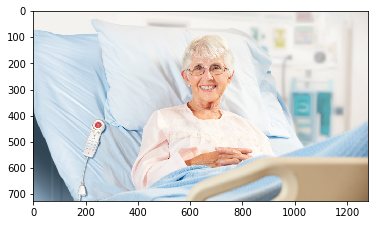

      LABEL     SCORE                                                VEC
1   patient  0.965435  [-0.03466797, 0.25, 0.09033203, 0.18164062, -0...
2      skin  0.859303  [-0.07714844, 0.33984375, 0.12011719, -0.27734...
3   sitting  0.839277  [0.21484375, 0.10595703, 0.080078125, 0.269531...
4   comfort  0.800011  [0.22949219, -0.0010223389, 0.06933594, 0.1054...
5   service  0.799269  [0.067871094, -0.041259766, 0.100097656, 0.058...
6  hospital  0.794108  [-0.09765625, 0.09765625, 0.091796875, 0.02404...


In [259]:
# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types

# Instantiates a client
client = vision.ImageAnnotatorClient()

# The name of the image file to annotate
file_name = 'imgs/female-patient.jpg'
img = mpimg.imread(file_name)
imgplot = plt.imshow(img)
plt.show()

# Loads the image into memory
with io.open(file_name, 'rb') as image_file:
    content = image_file.read()

image = types.Image(content=content)

# Performs label detection on the image file
response = client.label_detection(image=image)
labels = response.label_annotations

# Puts each label, its score, and its vector from the word2vec model into a dataframe
labels_df = pd.DataFrame(columns=['LABEL', 'SCORE'])
for label in labels:
    labels_df = labels_df.append({'LABEL': label.description.lower(),
                                  'SCORE': label.score},
                                  ignore_index=True)
labels_df = labels_df[labels_df['LABEL'].apply(lambda x: x in model)]
labels_df['VEC'] = labels_df.apply(lambda row: model[row.LABEL], axis=1)
print(labels_df)

In [260]:
# Finds the linear combination of all the labels' vectors, using their scores as coefficients
linear_combo = (labels_df['SCORE'] * labels_df['VEC']).sum()

# Finds the identity whose vector has the lowest cosine distance from the linear combination
temp_identities_df = copy.deepcopy(identities_df)
temp_identities_df['DISTANCE'] = temp_identities_df['VEC'].apply(lambda x: scipy.spatial.distance.cosine(x, linear_combo))
object_identity = temp_identities_df.loc[temp_identities_df['DISTANCE'].idxmin()]

object_identity

IDENTITY                                              patient
M_E                                                      0.07
M_P                                                     -1.72
M_A                                                     -0.78
F_E                                                      0.26
F_P                                                     -1.55
F_A                                                     -0.97
FILTERS                                      11 000001000 001
VEC         [-0.03466797, 0.25, 0.09033203, 0.18164062, -0...
DISTANCE                                             0.315843
Name: 472, dtype: object

In [258]:
# User sets the self identity and gender of the artificial agent
input_identity = 'doctor'
agent_gender = 'm'
agent_identity = identities_df[identities_df['IDENTITY'] == input_identity].squeeze()
agent_identity

IDENTITY                                               doctor
M_E                                                       1.8
M_P                                                      2.14
M_A                                                     -0.31
F_E                                                      1.72
F_P                                                      1.84
F_A                                                     -0.29
FILTERS                                      11 000001000 101
VEC         [-0.09326172, 0.02734375, 0.079589844, -0.0128...
Name: 199, dtype: object

In [87]:
from itertools import compress
from operator import mul, sub
from functools import reduce

# Calculates the affective meaning deflection of a given ABO event
def calc_deflection(agent_identity, behavior, object_identity, agent_gender):
    def calc_impressions(equations_df, sentiments):
        def calc_term(constant, terms, sentiments):
            terms_list = list(compress(sentiments, [bool(int(i)) for i in list(terms)[1:]]))
            terms_list.append(constant)
            return reduce(mul, terms_list)
        A_E = equations_df.apply(lambda row: calc_term(row.A_E, row.TERMS, sentiments), axis=1).sum()
        A_P = equations_df.apply(lambda row: calc_term(row.A_P, row.TERMS, sentiments), axis=1).sum()
        A_A = equations_df.apply(lambda row: calc_term(row.A_A, row.TERMS, sentiments), axis=1).sum()
        B_E = equations_df.apply(lambda row: calc_term(row.B_E, row.TERMS, sentiments), axis=1).sum()
        B_P = equations_df.apply(lambda row: calc_term(row.B_P, row.TERMS, sentiments), axis=1).sum()
        B_A = equations_df.apply(lambda row: calc_term(row.B_A, row.TERMS, sentiments), axis=1).sum()
        O_E = equations_df.apply(lambda row: calc_term(row.O_E, row.TERMS, sentiments), axis=1).sum()
        O_P = equations_df.apply(lambda row: calc_term(row.O_P, row.TERMS, sentiments), axis=1).sum()
        O_A = equations_df.apply(lambda row: calc_term(row.O_A, row.TERMS, sentiments), axis=1).sum()
        impressions = [A_E, A_P, A_A, B_E, B_P, B_A, O_E, O_P, O_A]
        return impressions
    if agent_gender == 'm':
        equations_df = m_equations_df
        a_e, a_p, a_a = agent_identity[['M_E', 'M_P', 'M_A']]
        b_e, b_p, b_a = behavior[['M_E', 'M_P', 'M_A']]
        o_e, o_p, o_a = object_identity[['M_E', 'M_P', 'M_A']]
    elif agent_gender == 'f':
        equations_df = f_equations_df
        a_e, a_p, a_a = agent_identity[['F_E', 'F_P', 'F_A']]
        b_e, b_p, b_a = behavior[['F_E', 'F_P', 'F_A']]
        o_e, o_p, o_a = object_identity[['F_E', 'F_P', 'F_A']]
    else:
        print('Sorry! Non-binary impression formation equations being added soon!')
        return
    sentiments = [a_e, a_p, a_a, b_e, b_p, b_a, o_e, o_p, o_a]
    impressions = calc_impressions(equations_df, sentiments)
    deflection = sum([(a - b) ** 2 for a, b in zip(impressions, sentiments)])
    return deflection

test_behavior = behaviors_df[behaviors_df['BEHAVIOR'] == 'aid'].squeeze()
print('Doctor Aid Patient - Deflection = {}'.format(calc_deflection(agent_identity, test_behavior, object_identity, agent_gender)))
test_behavior = behaviors_df[behaviors_df['BEHAVIOR'] == 'threaten'].squeeze()
print('Doctor Threaten Patient - Deflection = {}'.format(calc_deflection(agent_identity, test_behavior, object_identity, agent_gender)))

Doctor Aid Patient - Deflection = 1.0613237167878706
Doctor Threaten Patient - Deflection = 11.312363501469527


In [165]:
# Filters out behaviors that do not match the context of the actor and the object
# Example: ogle is a sexual behavior that should not be valid with a doctor actor and a patient object
def filter_behavior(agent_identity, behavior, object_identity):
    agent_filters = list(agent_identity.FILTERS)[4:13]
    behavior_filters = list(behavior.FILTERS)[4:13]
    behavior_surmised = list(behavior.FILTERS)[2]
    object_filters = list(object_identity.FILTERS)[4:13]
    if behavior_surmised == '1':
        return False
    for i in range(len(agent_filters)):
        if ((agent_filters[i] == '1' and behavior_filters[i] != '1')):
            return False
    return True

In [124]:
def normalize(df, features):
    result = df.copy()
    for feature_name in features:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [261]:
# Filter out 
temp_behaviors_df = copy.deepcopy(behaviors_df)
index = temp_behaviors_df.apply(lambda row: filter_behavior(agent_identity, row, object_identity), axis=1)
temp_behaviors_df = temp_behaviors_df[index]

# Cull the possible behaviors using a maximum affective meaning deflection threshold
temp_behaviors_df['DEFLECTION'] = temp_behaviors_df.apply(lambda row: calc_deflection(agent_identity, row, object_identity, agent_gender), axis=1)

# Find the conceptual distance of each behavior from the actor and object
temp_behaviors_df['ACTOR_DISTANCE'] = temp_behaviors_df['VEC'].apply(lambda x: scipy.spatial.distance.cosine(x, agent_identity.VEC))
temp_behaviors_df['OBJECT_DISTANCE'] = temp_behaviors_df['VEC'].apply(lambda x: scipy.spatial.distance.cosine(x, object_identity.VEC))

# Normalize the values of each metric
temp_behaviors_df = normalize(temp_behaviors_df, ['DEFLECTION', 'ACTOR_DISTANCE', 'OBJECT_DISTANCE'])

In [262]:
deflection_weight = .5
actor_weight = 0.1
object_weight = 0.1

# Calculate a weighted sum of both the deflection rating of each behavior and its conceptual distance from the actor and the object
temp_behaviors_df['COMBINED'] = (deflection_weight * temp_behaviors_df['DEFLECTION'] + 
                                 actor_weight * temp_behaviors_df['ACTOR_DISTANCE'] + 
                                 object_weight * temp_behaviors_df['OBJECT_DISTANCE'])

# Select the behavior with the lowest combined deflection + vector distance score
selected_behavior = temp_behaviors_df.loc[temp_behaviors_df['COMBINED'].idxmin()]
selected_behavior

BEHAVIOR                                                    medicate
M_E                                                             1.68
M_P                                                             1.49
M_A                                                            -0.81
F_E                                                             0.85
F_P                                                             0.88
F_A                                                             0.22
FILTERS                                             10 000001010 100
VEC                [0.091308594, 0.15722656, -0.16992188, 0.63671...
DEFLECTION                                                 0.0350659
ACTOR_DISTANCE                                              0.146514
OBJECT_DISTANCE                                             0.135353
COMBINED                                                   0.0457196
Name: 372, dtype: object

In [263]:
print('Final ABO: {} {} {}.'.format(agent_identity.IDENTITY, selected_behavior.BEHAVIOR, object_identity.IDENTITY))

Final ABO: doctor medicate patient.


In [264]:
sorted_behaviors_df = temp_behaviors_df.sort_values('COMBINED')
rows = sorted_behaviors_df.shape[0] - 1
for div in [0., .25, .5, .75, 1.]:
    idx = int(rows * div)
    print(sorted_behaviors_df.iloc[idx])

BEHAVIOR                                                    medicate
M_E                                                             1.68
M_P                                                             1.49
M_A                                                            -0.81
F_E                                                             0.85
F_P                                                             0.88
F_A                                                             0.22
FILTERS                                             10 000001010 100
VEC                [0.091308594, 0.15722656, -0.16992188, 0.63671...
DEFLECTION                                                 0.0350659
ACTOR_DISTANCE                                              0.146514
OBJECT_DISTANCE                                             0.135353
COMBINED                                                   0.0457196
Name: 372, dtype: object
BEHAVIOR                                                    confront
M_E      